In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r'C:\Users\One\Git\COURSERA YANDEX\Course 5\week 18\задание\WAG_C_M.csv', delimiter = ';')
data.head()

,month,WAG_C_M
0,01.01.1993,15.3
1,01.02.1993,19.1
2,01.03.1993,23.6
3,01.04.1993,30.6
4,01.05.1993,37.5


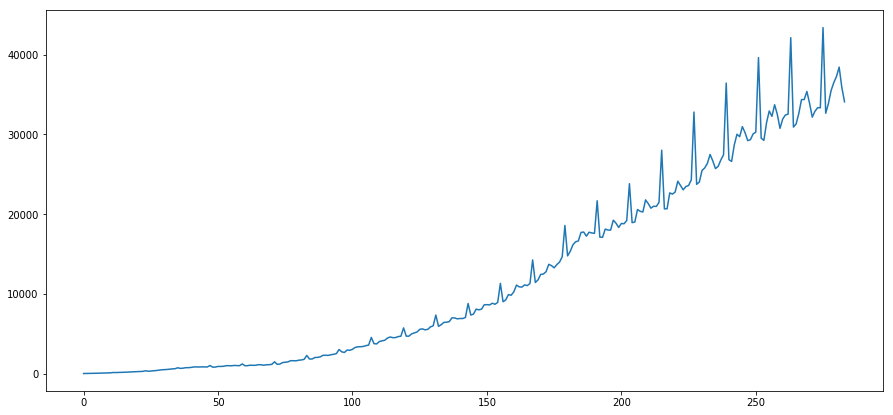

In [2]:
plt.figure(figsize=(15,7))

plt.plot(data.WAG_C_M)

## Выполним преобразование Бокса-Кокса и снова посмотрим на данные

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


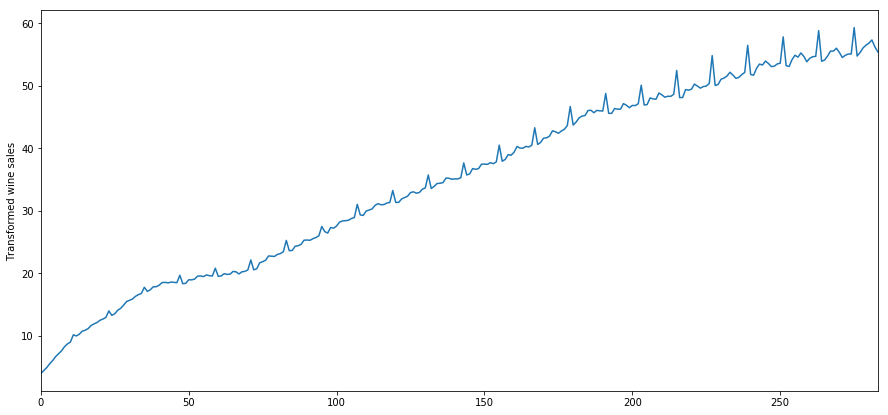

In [3]:
from scipy import stats
import statsmodels.api as sm


data.WAG_C_M, lmbda = stats.boxcox(data.WAG_C_M)
plt.figure(figsize=(15,7))
data.WAG_C_M.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.WAG_C_M)[1])

In [4]:
data.head()

,month,WAG_C_M
0,01.01.1993,3.990393
1,01.02.1993,4.458758
2,01.03.1993,4.931635
3,01.04.1993,5.549430
4,01.05.1993,6.063406


## Налицо тренд и сезонность ряда. Критерий Дики-Фулера не отвергает гипотезу нестационарности.

In [5]:
data.head()
data['wage_diff'] = data.WAG_C_M - data.WAG_C_M.shift(12)

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x360 with 0 Axes>

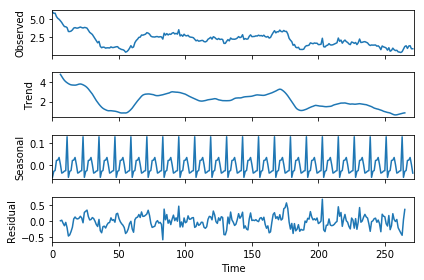

In [6]:
plt.figure(figsize=(15,5))
sm.tsa.seasonal_decompose(np.asarray(data.wage_diff)[12:], freq=12).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.wage_diff[12:])[1])

In [7]:
data['wage_diff2'] = data['wage_diff'] - data['WAG_C_M'].shift(13)

Критерий Дики-Фуллера: p=0.597066


<Figure size 1080x720 with 0 Axes>

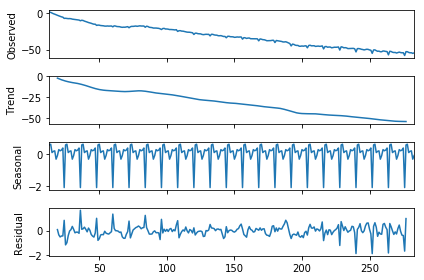

In [8]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose((data['wage_diff2'])[13:], freq=12).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data['wage_diff2'][13:])[1])

## Критерий Дики-Фулера после двух дифференцирований снова не отвергает гипотезу нестационарности, а тренд варьируется уже не в пределах [0; 5], а [-50; 0] (дифференцирование в пределах 12+/-3 месяца дает тот же эффект, не отображаю). Думаю, лучше оставить только сезонное дифференцирование.

In [9]:
data.head(15)

,month,WAG_C_M,wage_diff,wage_diff2
0,01.01.1993,3.990393,NaN,NaN
1,01.02.1993,4.458758,NaN,NaN
2,01.03.1993,4.931635,NaN,NaN
3,01.04.1993,5.549430,NaN,NaN
4,01.05.1993,6.063406,NaN,NaN
5,01.06.1993,6.690719,NaN,NaN
6,01.07.1993,7.161310,NaN,NaN
7,01.08.1993,7.618224,NaN,NaN
8,01.09.1993,8.275619,NaN,NaN
9,01.10.1993,8.726834,NaN,NaN


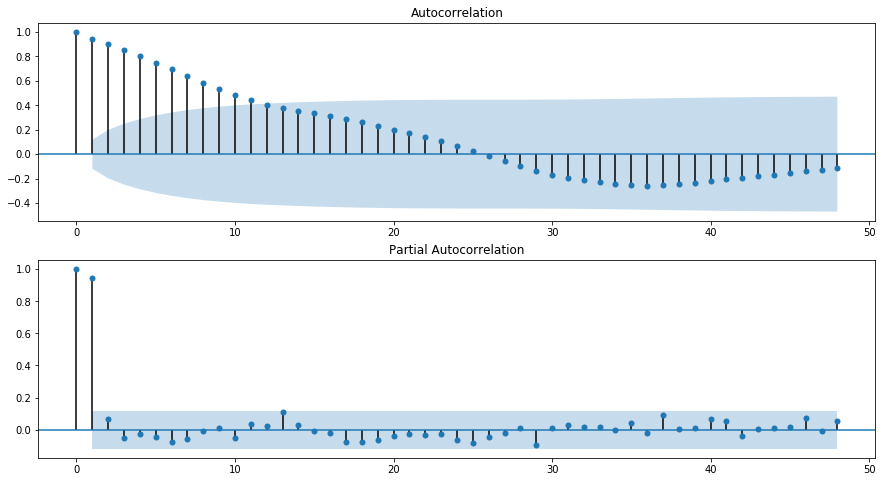

In [10]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data['wage_diff'][12:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data['wage_diff'][12:].values.squeeze(), lags=48, ax=ax)
plt.show()

## Выбираю начальные приближения: Q=0, q=11, P=0, p=1. После прогона куска закомментиованного кода получил оптимальные параметры, заняло около 20 мин, поэтому экономлю ваше время

In [11]:
"""
ps = range(0, 2)
d=1
qs = range(0, 12)
Ps = range(0, 3)
D=1
Qs = range(0, 3)
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)
"""

'\nps = range(0, 2)\nd=1\nqs = range(0, 12)\nPs = range(0, 3)\nD=1\nQs = range(0, 3)\nfrom itertools import product\nparameters = product(ps, qs, Ps, Qs)\nparameters_list = list(parameters)\nlen(parameters_list)\n'

In [12]:
"""
results = []
"""

'\nresults = []\n'

In [13]:
"""
%%time
best_aic = float("inf")
import warnings
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')
"""

'\n%%time\nbest_aic = float("inf")\nimport warnings\nwarnings.filterwarnings(\'ignore\')\n\nfor param in parameters_list:\n    #try except нужен, потому что на некоторых наборах параметров модель не обучается\n    try:\n        model=sm.tsa.statespace.SARIMAX(data.WAG_C_M, order=(param[0], d, param[1]), \n                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)\n    #выводим параметры, на которых модель не обучается и переходим к следующему набору\n    except ValueError:\n        print(\'wrong parameters:\', param)\n        continue\n    aic = model.aic\n    #сохраняем лучшую модель, aic, параметры\n    if aic < best_aic:\n        best_model = model\n        best_aic = aic\n        best_param = param\n    results.append([param, model.aic])\n    \nwarnings.filterwarnings(\'default\')\n'

In [14]:
"""
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

"""

"\nresult_table = pd.DataFrame(results)\nresult_table.columns = ['parameters', 'aic']\nprint(result_table.sort_values(by = 'aic', ascending=True).head())\n\n"

In [15]:
#после прогона предыдущего блока было установлено лучшее сочетание параметров
D, d = 1, 1
parameters = (1, 3, 2, 2)
best_model=sm.tsa.statespace.SARIMAX(data.WAG_C_M, order=(parameters[0], d, parameters[1]), 
                                        seasonal_order=(parameters[2], D, parameters[3], 12)).fit(disp=-1)
aic = best_model.aic

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [16]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            WAG_C_M   No. Observations:                  284
Model:             SARIMAX(1, 1, 3)x(2, 1, 2, 12)   Log Likelihood                  18.542
Date:                            Wed, 01 Jan 2020   AIC                            -19.083
Time:                                    20:16:55   BIC                             13.336
Sample:                                         0   HQIC                            -6.067
                                            - 284                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7679      0.134      5.725      0.000       0.505       1.031
ma.L1         -0.9469      0.139   

Критерий Стьюдента: p=0.534874
Критерий Дики-Фуллера: p=0.000000


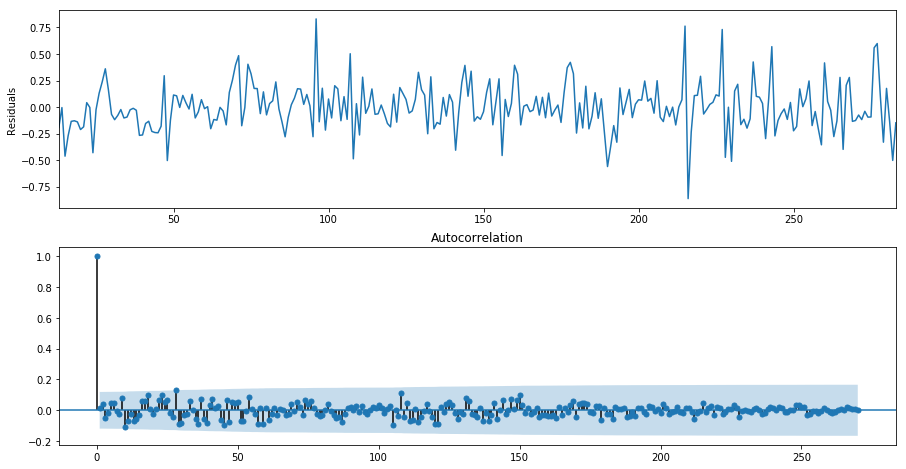

In [17]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

## Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой)

In [18]:
data.tail()

,month,WAG_C_M,wage_diff,wage_diff2
279,01.04.2016,56.526742,0.942729,-53.837340
280,01.05.2016,56.860441,1.275065,-54.308948
281,01.06.2016,57.358885,1.316994,-54.268383
282,01.07.2016,56.260153,0.893671,-55.148220
283,01.08.2016,55.455409,0.896620,-54.469862


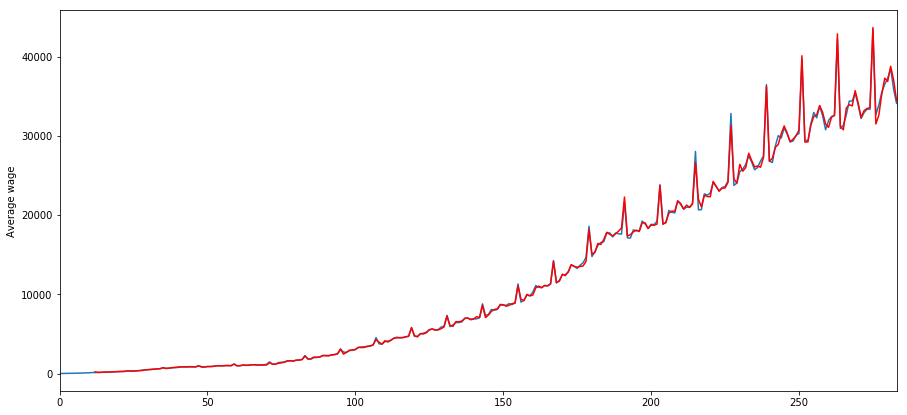

In [19]:
# Посмотрим, насколько хорошо модель описывает данные:
    

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    
    
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
data.WAG_C_M = invboxcox(data.WAG_C_M, lmbda)
plt.figure(figsize = (15,7))
data.WAG_C_M.plot()
data.model[12:].plot(color='r')
plt.ylabel('Average wage')
plt.show()

## Предсказание достаточно точно. Построим прогноз натренированной модели.

In [20]:
import time
from dateutil.relativedelta import relativedelta
import datetime

In [21]:
data_new = data[['month', 'WAG_C_M']]
data_new['month'] = [datetime.datetime.strptime(x, '%d.%m.%Y') for x in data_new['month']]
date_list = [datetime.datetime.strptime("01.09.2016", '%d.%m.%Y') + relativedelta(months=x) for x in range(0,36)]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
future = pd.DataFrame(date_list)
future.columns = ['month']

In [23]:
future['WAG_C_M'] = pd.DataFrame(invboxcox(best_model.predict(start=283, end=318), lmbda)).values

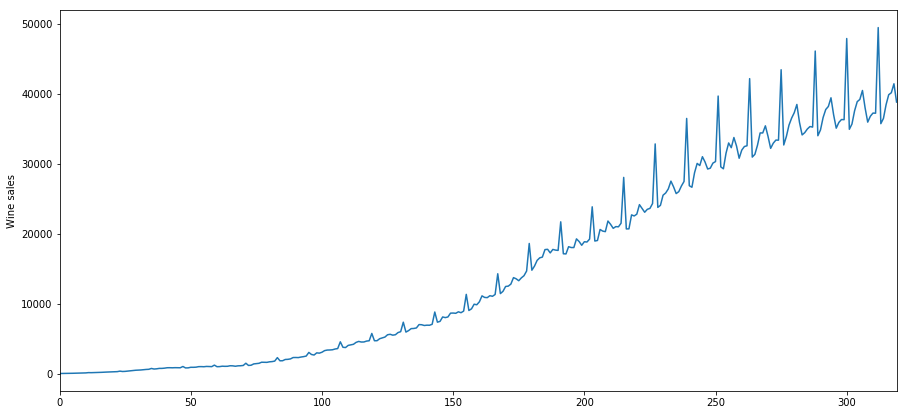

In [24]:
data_new = pd.concat([data_new[['month', 'WAG_C_M']], future], ignore_index = True)

plt.figure(figsize=(15,7))
data_new.WAG_C_M.plot()
plt.ylabel('Wine sales')
plt.show()

## Прогноз выглядит правдоподобно: виден тренд и сезонность, сохранена цикличность.